# Optimize Marketing Spend Using Machine Learning Algorithms

## Introduction


We help e-commerce operators optimize their marketing budget to maximize revenue and ROI using machine learning models:
  * Random forest
  * Light gradient boosting
  * Extreme gradient boosting

## Data Preparation

### Load dataframe


In [298]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing

pd.set_option('display.max_columns', 200)
df = pd.read_csv("sample_data.csv")
df.head()

,Lead Id,Lead Owner,Interest Level,Lead created,Lead Location(Auto),Creation Source,Next activity,What do you do currently ?,What are you looking for in Product ?,Website Source,Lead Last Update time,Marketing Source,Lead Location(Manual),Demo Date,Demo Status,Closure date
0,5e502dcf828b8975a78e89f3e9aeac12,e14c3a,Not Interested,12-01-2023 16:42,IN,API,NaN,Student,NaN,NaN,12-01-2023 19:27,NaN,India,NaN,NaN,NaN
1,efe3f074c61959c2ea1906dd0346aa69,d16267,Slightly Interested,04-12-2021 09:32,NaN,API,12-01-2022 00:00,NaN,NaN,Sales lead,12-01-2022 17:17,Paid - Instagram,India,05-12-2021 00:00,No Show,NaN
2,d26dc5cd5843622a203cf396b4ee4b1a,d138f9,No Answer,15-04-2022 10:16,NaN,API,16-04-2022 00:00,NaN,NaN,NaN,16-04-2022 20:35,Paid-Adwords,In,NaN,NaN,NaN
3,d50acaedc1e5b9c18f8ceb3c6cff345b,38e2a6,Not Interested,21-10-2022 17:02,IN,API,23-10-2022 00:00,fresher,NaN,NaN,02-12-2022 13:35,Paid-Adwords,IN,22-11-2022 00:00,Scheduled,NaN
4,07758f3d12a23e68bb3b58b8009dd9a8,d130bb,Not Interested,25-10-2021 10:48,NaN,API,NaN,NaN,NaN,Sales lead,13-11-2021 14:51,Affiliate,India,NaN,NaN,NaN


### Exploratory Data Analysis

In [299]:
df.shape

(38984, 16)

In [300]:
df.columns

Index(['Lead Id', 'Lead Owner', 'Interest Level', 'Lead created',
       'Lead Location(Auto)', 'Creation Source', 'Next activity',
       'What do you do currently ?', 'What are you looking for in Product ?',
       'Website Source', 'Lead Last Update time', 'Marketing Source',
       'Lead Location(Manual)', 'Demo Date', 'Demo Status', 'Closure date'],
      dtype='object')

In [301]:
df.describe()

,Lead Id,Lead Owner,Interest Level,Lead created,Lead Location(Auto),Creation Source,Next activity,What do you do currently ?,What are you looking for in Product ?,Website Source,Lead Last Update time,Marketing Source,Lead Location(Manual),Demo Date,Demo Status,Closure date
count,38984,38984,38847,38984,10810,38984,14776,16909,9970,24088,38984,28339,34974,10851,11423,629
unique,37450,23,8,35951,169,3,2610,6831,4046,10,32693,46,415,583,3,277
top,bcbcf737090f0a52c59237fb0ee921d5,2f6f7f,Slightly Interested,13-01-2022 14:05,IN,API,31-01-2023 00:00,Student,DS,Sales lead,06-03-2023 17:53,SEO,IN,30-07-2022 00:00,Scheduled,01-05-2022 00:00
freq,6,5643,14572,17,6735,36291,74,3406,481,23121,401,10127,14126,48,4000,9


In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Lead Id                                38984 non-null  object
 1   Lead Owner                             38984 non-null  object
 2   Interest Level                         38847 non-null  object
 3   Lead created                           38984 non-null  object
 4   Lead Location(Auto)                    10810 non-null  object
 5   Creation Source                        38984 non-null  object
 6   Next activity                          14776 non-null  object
 7   What do you do currently ?             16909 non-null  object
 8   What are you looking for in Product ?  9970 non-null   object
 9   Website Source                         24088 non-null  object
 10  Lead Last Update time                  38984 non-null  object
 11  Marketing Sourc

### Data Preparation

In [303]:
# update data format
df['Lead created'] = pd.to_datetime(df['Lead created'], format="%d-%m-%Y %H:%M", dayfirst=True)
df['Lead Last Update time'] = pd.to_datetime(df['Lead Last Update time'], format="%d-%m-%Y %H:%M", dayfirst=True)
df['Next activity'] = pd.to_datetime(df['Next activity'], format="%d-%m-%Y %H:%M", dayfirst=True)
df['Demo Date'] = pd.to_datetime(df['Demo Date'], format="%d-%m-%Y %H:%M", dayfirst=True)


# address missing values in 'Interest Level' columns by dropping the value-missing row
df['Interest Level'].isna().sum()
df = df[df['Interest Level'].notna()]
df['Interest Level'].value_counts()

,count
Interest Level,
Slightly Interested,14572
Not Interested,10545
No Answer,9254
Not called,1585
Fairly Interested,1320
Closed,811
Invalid Number,636
Very Interested,124


In [304]:
# drop the rows with values of "Not called", "Closed", "Invalid Number"
df = df[~df['Interest Level'].isin(["Not called", "Closed", "Invalid Number"])]
df['Interest Level'].value_counts()

,count
Interest Level,
Slightly Interested,14572
Not Interested,10545
No Answer,9254
Fairly Interested,1320
Very Interested,124


In [305]:
# assign numeric values to the "Interest Level" values: Not interested, No Answer = 0, Interested = 1
df['Interest Level'] = df['Interest Level'].apply(lambda x: 1 if x in ["Slightly Interested", "Fairly Interested", "Very Interested"] else 0)
df['Interest Level'].value_counts()

,count
Interest Level,
0,19799
1,16016


In [306]:
# drop unnecessary columns
df = df.drop(["Lead Id", "Lead Location(Auto)", "Next activity", "What are you looking for in Product ?", "Lead Last Update time", "Lead Location(Manual)", "Demo Date", "Demo Status", "Closure date"], axis=1)
df.columns

Index(['Lead Owner', 'Interest Level', 'Lead created', 'Creation Source',
       'What do you do currently ?', 'Website Source', 'Marketing Source'],
      dtype='object')

In [307]:
# add hour_of_day and day_of_week columns
df['hour_of_day'] = df['Lead created'].dt.hour
df['day_of_week'] = df['Lead created'].dt.weekday
df = df.drop(["Lead created"], axis=1)

In [308]:
# address "What do you do currently ?" column
df['What do you do currently ?'].value_counts()

,count
What do you do currently ?,
Student,3376
student,1254
Fresher,296
Working,192
Data Engineer,136
...,...
Completed mba in civil,1
Into automation,1
Stu - Btech Final year,1


In [309]:
# add a label: student = 1, others = 0
df['What do you do currently ?'] = df['What do you do currently ?'].apply(lambda x: 1 if 'student' in str(x).strip().lower() else 0)

In [310]:
# address "Marketing Source" column
df['Marketing Source'].value_counts()

,count
Marketing Source,
SEO,9751
Paid - Instagram,3738
Paid-Adwords,3258
Paid-YouTube,2376
Affiliate,2215
Medium,2045
Paid - Facebook,1436
Email Campaign,813
Paid - Linkedin,136


In [311]:
# drop "Unknown" rows to improve the performance
df['Marketing Source'].fillna("Unknown", inplace=True)

#### Label Encoding

**Transforming Categorical Variables**

Transforming categorical variables is a crucial step in data preprocessing for machine learning.

Common methods to convert categorical data into a suitable format for analysis:
* One-hot encoding
 * Create binary variables for each category
 * Good for categories with a natural order
* Label encoding
 * Assign unique integers to categories

In [312]:
# transform 3 columns using label encoding
label_encoder1 = preprocessing.LabelEncoder()
df['Marketing Source']= label_encoder1.fit_transform(df['Marketing Source'])


label_encoder2 = preprocessing.LabelEncoder()
df['Lead Owner']= label_encoder2.fit_transform(df['Lead Owner'])


label_encoder3 = preprocessing.LabelEncoder()
df['Creation Source']= label_encoder3.fit_transform(df['Creation Source'])

df.head()

,Lead Owner,Interest Level,Creation Source,What do you do currently ?,Website Source,Marketing Source,hour_of_day,day_of_week
0,20,0,0,1,NaN,42,16,3
1,18,1,0,0,Sales lead,13,9,5
2,17,0,0,0,NaN,19,10,4
3,5,0,0,0,NaN,19,17,4
4,16,0,0,0,Sales lead,0,10,0


### Prediction & Evaluation

In [313]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


X = df[["Lead Owner", "What do you do currently ?", "Marketing Source", "Creation Source", "hour_of_day", "day_of_week"]]
y = df["Interest Level"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,Lead Owner,What do you do currently ?,Marketing Source,Creation Source,hour_of_day,day_of_week
2201,19,1,42,0,4,2
29205,4,1,24,0,19,2
24325,18,0,6,0,3,1
20499,1,0,42,0,16,1
34645,17,0,24,0,12,0


Random Forest 0.6963562753036437


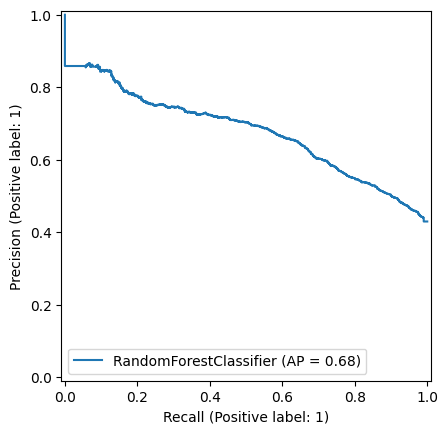

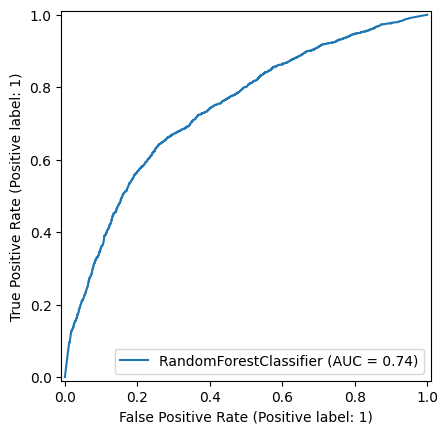

In [314]:
# train models and evaluate performance with accuracy score, PR curve, and ROC curve

## 1. random forest
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)

print("Random Forest", accuracy_score(rf.predict(X_test), y_test))
PrecisionRecallDisplay.from_estimator(rf, X_test, y_test)
RocCurveDisplay.from_estimator(rf, X_test, y_test)

XGBoost 0.731257852854949


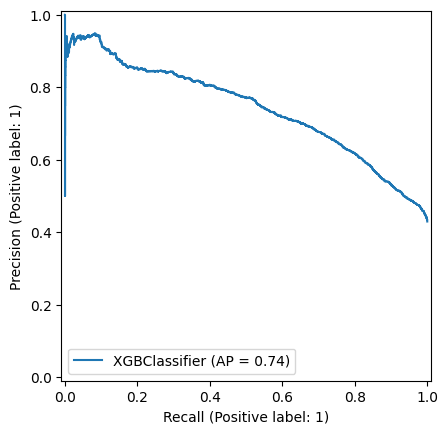

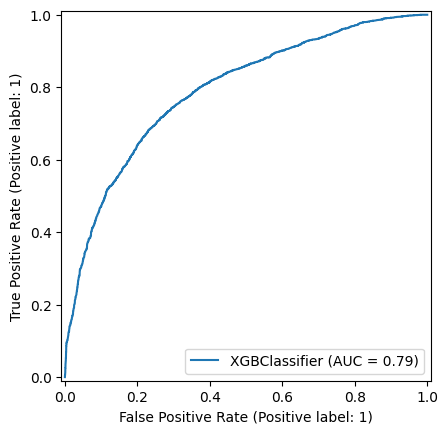

In [315]:
## 2. xg boost
xgb = XGBClassifier(n_estimators=300, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=3)
xgb.fit(X_train, y_train)

print("XGBoost", accuracy_score(xgb.predict(X_test), y_test))
PrecisionRecallDisplay.from_estimator(xgb, X_test, y_test)
RocCurveDisplay.from_estimator(xgb, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12940, number of negative: 15712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 28652, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451626 -> initscore=-0.194101
[LightGBM] [Info] Start training from score -0.194101
Light GBM 0.7300013960631021


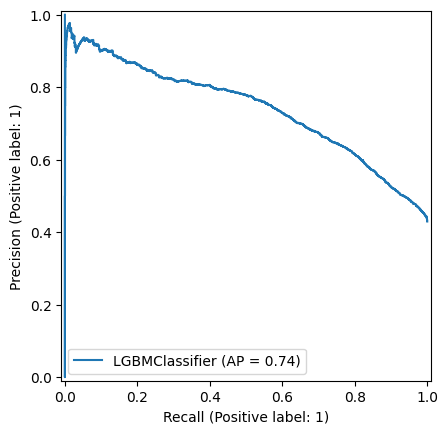

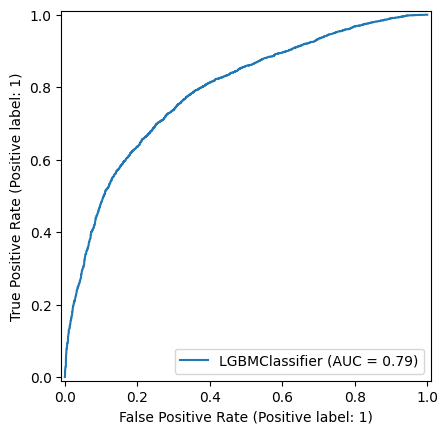

In [316]:
## 3. Light GB
lgb = LGBMClassifier(n_estimators=300)
lgb.fit(X_train, y_train)

print("Light GBM", accuracy_score(lgb.predict(X_test), y_test))
PrecisionRecallDisplay.from_estimator(lgb, X_test, y_test)
RocCurveDisplay.from_estimator(lgb, X_test, y_test)

### Conclusion

In this project, we predict customer interest in a lead using supervised models, using **binary classification** to determine confidence levels.

And it turns out that **LightGBM** has the most accurate performance based on PR and ROC curves.


To generate the accurate performance, it is important to
- define the problem we want to tackle,
- preprocess the data with assumptions,
- select suitable machine learning algorithms, and
- optimize the models

## Appendix

### Read CSV stored in different locations

##### Local storage
```
import pandas as pd
csv_file_path= "absolute-path-to-the-csv-file/csv-file-name.csv"
df = pd.read_csv(csv_file_path)
```


##### Colab - CSV Format

```
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')
csv_file_path= '/content/drive/your-google-drive-path/csv-file-name.csv'
df = pd.read_csv(csv_file_path)
```

##### AWS S3 - CSV
```
s3_link = 'https://s3.amazonaws.com/your-project-url/csv-file-name.csv'
df = pd.read_csv(s3_link)
```



### Supervised Learning

* A machine learning technique where a model is trained on a dataset with both inputs and their corresponding correct outputs.

* The model learns to predict outputs for new inputs by minimizing the error between its predictions and the actual outputs.

* Two main types of supervised learning problems:

1) Classification:
- Assigning data to specific categories
- i.e., Linear classifiers, SVM, decision trees, k-nearest neighbor, random forest.

2) Regression:
- Understanding the relationship between variables to make predictions
- i.e., Linear regression, logistical regression, polynomial regression.


#### Decision Trees
- Non-parametric supervised learning algorithms used for classification and regression
- Use a hierarchical tree structure to make decisions.

- The learning process involves a **divide-and-conquer strategy**, splitting data into smaller subsets based on features. This process continues until all data points are classified or a certain level of purity is achieved.

- **Overfitting** can occur when trees become too complex, leading to poor generalization. Pruning is used to remove unnecessary branches and prevent overfitting. Cross-validation is used to evaluate the model's performance.

#### Random Forest

Random Forest is an ensemble learning algorithm that builds multiple decision trees and combines their predictions to make a final decision. It's particularly effective at handling high-dimensional data and avoiding overfitting.


Key steps of the Random Forest algorithm:

Bootstrap sampling: Create subsets of the training data.
Feature selection: Choose a subset of features.
Decision tree creation: Build a decision tree using the subset.
Repeat: Repeat steps 1-3 to create multiple trees.
Combine predictions: Average the predictions of all trees.


Mathematics behind Random Forest:
Decision trees: Use recursive binary partitioning to split data based on feature values.
Bootstrap sampling: Create multiple versions of the dataset to reduce overfitting.

#### Bagging

- Combines multiple models (classifiers) trained on different bootstrap samples of the data.
- Reduces variance by averaging or voting predictions.
- Typically used for models with high variance and low bias (e.g., decision trees).

=> Each model learns from each other independently in parallel and combines them for determining the model average.

![image.png](https://media.geeksforgeeks.org/wp-content/uploads/20210707140912/Bagging.png)Credit: geeksforgeeks

#### Boosting

- Sequentially trains models, focusing on errors made by previous models.
- Assigns higher weights to misclassified data points.
- Reduces bias and variance by combining weak models into a strong one.
- Typically used for models with low variance and high bias.

=> Each model learns sequentially and adaptively to improve model predictions of a learning algorithm.

![image.png](https://media.geeksforgeeks.org/wp-content/uploads/20210707140911/Boosting.png)

Credit: geeksforgeeks

#### Gradient Boosting Trees

Gradient boosting is a machine learning technique that builds a strong model by combining many weak models (usually decision trees).

It's effective for both regression and classification tasks and often outperforms random forests. Popular implementations include XGBoost and LightGBM.

### Evaluation metrics

#### Classification Evaluation Metrics

**F1 Score**:
Combines precision and recall into a single value.
Calculated as the harmonic mean of precision and recall.
Ranges from 0 to 1, with 1 indicating perfect precision and recall.

$$ F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} $$



**Recall**:
Measures the ability to correctly identify positive instances.
Useful when the cost of false negatives is high.

$$ Recall = \frac{TP}{TP + FN} $$



**Precision**:
Measures the accuracy of positive predictions.
Useful when the cost of false positives is high.

$$ precision = \frac{true\ positive}{true\ positive + false\ positive} $$
where true positive refers to the cases where the model correctly predicted the positive class, and false positive refers to the cases where the model incorrectly predicted the positive class.



**Confusion Matrix**:
Table that compares predicted and true labels.
Shows true positives, false positives, true negatives, and false negatives.

|          | Actual Positive | Actual Negative |
|----------|----------------|----------------|
| Predicted Positive | True Positive (TP) | False Positive (FP) |
| Predicted Negative | False Negative (FN) | True Negative (TN) |

​


**ROC AUC Score**:
ROC AUC (Receiver Operating Characteristic Area Under the Curve) score measures a classifier's ability to distinguish between positive and negative classes.
Calculated as the area under the ROC curve.

$$ ROC\ AUC\ Score = \int_0^1 TPR(FPR^{-1}(t)) dt $$
where $FPR^{-1}$ is the inverse of the FPR function.



**Choosing the Right Metric**

- F1 score: Balanced precision and recall.
- Recall: High cost of false negatives.
- Precision: High cost of false positives.
- Confusion matrix: Overall performance visualization.
- ROC AUC score: Class separation ability.

**Precision-Recall (PR) curve** and **Area Under the Curve (AUC)** are evaluation metrics for binary classification.
- PR curve visualizes the trade-off between precision and recall.
- AUC summarizes the PR curve into a single value.

Threshold selection depends on the problem's requirements and the cost of false positives and negatives.




1. Accuracy

\begin{equation}
\text{Accuracy} = \frac{True Positive + True Negative}{True Positive + False Positive + True Negative + False Negative}
\end{equation}


2. Precision

\begin{equation}
\text{Precision} = \frac{True Positive}{True Positive + False Positive}
\end{equation}


3. Recall

\begin{equation}
\text{Recall} = \frac{True Positive}{True Positive + False Negative}
\end{equation}


4. F1-score

\begin{equation}
\text{F1-score} = 2 * \frac{Precision * Recall}{Precision + Recall}
\end{equation}


![image.png](https://blog.paperspace.com/content/images/2020/09/Fig01.jpg)